In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [22]:
# Load in the dataset
df = pd.read_csv("cleaned_heart_disease.csv")

# Combine to 2 classes
df['target'] = df['target'].apply(lambda x: 1 if x > 0 else 0)

print(df.head())

X = df.drop(columns=['target'])
y = df['target']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

    age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0  63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1  67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2  67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3  37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4  41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   

   target  
0       0  
1       1  
2       1  
3       0  
4       0  


# Optimization Visualizations
Creating graphs to understand the types of optimizations to make to reduce overfitting. Visually, this can allow us to determine the most optimal hyper parameters to change to reduce overfitting.

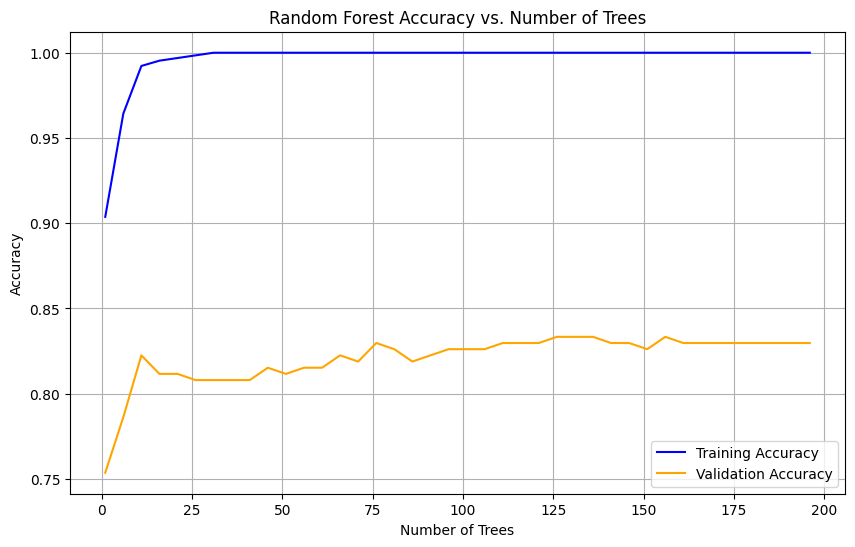

In [23]:
# Split into train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Track accuracy over number of trees
n_trees = list(range(1, 201, 5))  # From 1 to 200 trees, step of 5
train_acc = []
val_acc = []

for n in n_trees:
    rf = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, rf.predict(X_train)))
    val_acc.append(accuracy_score(y_test, rf.predict(X_test)))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(n_trees, train_acc, label='Training Accuracy', color='blue')
plt.plot(n_trees, val_acc, label='Validation Accuracy', color='orange')
plt.xlabel('Number of Trees')
plt.ylabel('Accuracy')
plt.title('Random Forest Accuracy vs. Number of Trees')
plt.legend()
plt.grid(True)
plt.show()

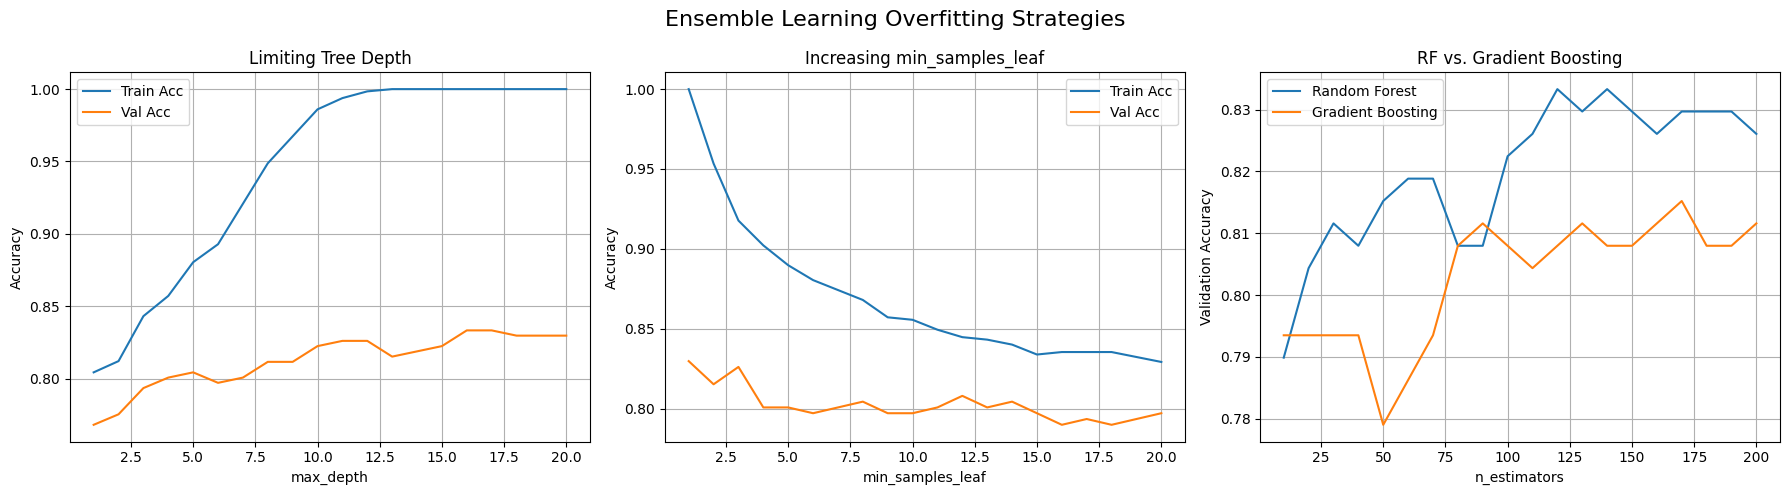

In [24]:
# Prepare plots
fig, axs = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Ensemble Learning Overfitting Strategies', fontsize=16)

# 1. Limit Tree Depth
depths = range(1, 21)
train_acc, val_acc = [], []
for d in depths:
    rf = RandomForestClassifier(max_depth=d, n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, rf.predict(X_train)))
    val_acc.append(accuracy_score(y_test, rf.predict(X_test)))
axs[0].plot(depths, train_acc, label='Train Acc')
axs[0].plot(depths, val_acc, label='Val Acc')
axs[0].set_title('Limiting Tree Depth')
axs[0].set_xlabel('max_depth')
axs[0].set_ylabel('Accuracy')
axs[0].legend()
axs[0].grid(True)

# 2. min_samples_leaf
min_leaf = range(1, 21)
train_acc, val_acc = [], []
for leaf in min_leaf:
    rf = RandomForestClassifier(min_samples_leaf=leaf, n_estimators=100, random_state=42)
    rf.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, rf.predict(X_train)))
    val_acc.append(accuracy_score(y_test, rf.predict(X_test)))
axs[1].plot(min_leaf, train_acc, label='Train Acc')
axs[1].plot(min_leaf, val_acc, label='Val Acc')
axs[1].set_title('Increasing min_samples_leaf')
axs[1].set_xlabel('min_samples_leaf')
axs[1].set_ylabel('Accuracy')
axs[1].legend()
axs[1].grid(True)

# 3. Random Forest vs. Gradient Boosting (fixed params)
n_estimators = list(range(10, 201, 10))
rf_val_acc, gb_val_acc = [], []
for n in n_estimators:
    rf = RandomForestClassifier(n_estimators=n, max_depth=10, random_state=42)
    rf.fit(X_train, y_train)
    rf_val_acc.append(accuracy_score(y_test, rf.predict(X_test)))
    
    gb = GradientBoostingClassifier(n_estimators=n, max_depth=3, random_state=42)
    gb.fit(X_train, y_train)
    gb_val_acc.append(accuracy_score(y_test, gb.predict(X_test)))

axs[2].plot(n_estimators, rf_val_acc, label='Random Forest')
axs[2].plot(n_estimators, gb_val_acc, label='Gradient Boosting')
axs[2].set_title('RF vs. Gradient Boosting')
axs[2].set_xlabel('n_estimators')
axs[2].set_ylabel('Validation Accuracy')
axs[2].legend()
axs[2].grid(True)

plt.tight_layout()
plt.show()


# GridSearch to Optimize HyperParameters

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 10, 'n_estimators': 300}
Train Accuracy: 0.8494, Test Accuracy: 0.8043


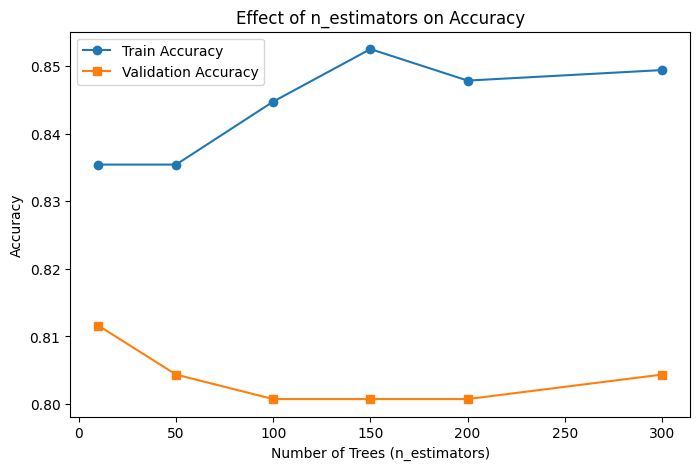

In [25]:
# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [5, 10, 15, None],  # None = unlimited depth
    'min_samples_leaf': [1, 2, 5, 10]
}

# Perform grid search with cross-validation
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Train and test accuracy
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)
print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

# Plot learning curve for different estimators
train_accuracies, test_accuracies = [], []
n_estimators_range = [10, 50, 100, 150, 200, 300]

# Extract the best parameters but remove 'n_estimators'
best_params = grid_search.best_params_.copy()  # Make a copy to avoid modifying the original
best_params.pop('n_estimators')  # Remove 'n_estimators' to avoid duplication

for n in n_estimators_range:
    model = RandomForestClassifier(n_estimators=n, **best_params, random_state=42)
    model.fit(X_train, y_train)
    train_accuracies.append(model.score(X_train, y_train))
    test_accuracies.append(model.score(X_test, y_test))

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_range, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(n_estimators_range, test_accuracies, label="Validation Accuracy", marker='s')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Effect of n_estimators on Accuracy")
plt.legend()
plt.show()

Best Hyperparameters: {'max_depth': 5, 'min_samples_leaf': 2, 'n_estimators': 100}
Train Accuracy: 0.8465, Test Accuracy: 0.8207


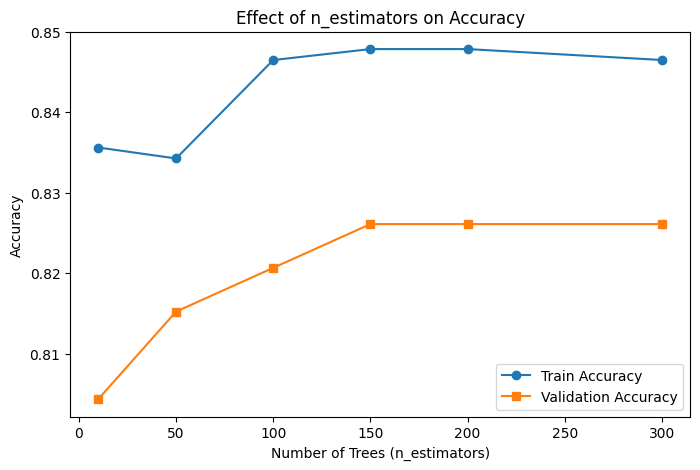

In [26]:
# See how applying the PCA values from pca_approach.ipynb work...
# Apply PCA
pca = PCA(n_components=0.85)  # Retain 85% of variance (optimal finding from grid search below)
X_pca = pca.fit_transform(X_scaled)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42, stratify=y)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [5, 10, 15, None],  # None = unlimited depth
    'min_samples_leaf': [1, 2, 5, 10]
}

# Perform grid search with cross-validation
rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

# Train and test accuracy
train_acc = best_model.score(X_train, y_train)
test_acc = best_model.score(X_test, y_test)
print(f"Train Accuracy: {train_acc:.4f}, Test Accuracy: {test_acc:.4f}")

# Plot learning curve for different estimators
train_accuracies, test_accuracies = [], []
n_estimators_range = [10, 50, 100, 150, 200, 300]

# Extract the best parameters but remove 'n_estimators'
best_params = grid_search.best_params_.copy()  # Make a copy to avoid modifying the original
best_params.pop('n_estimators')  # Remove 'n_estimators' to avoid duplication

for n in n_estimators_range:
    model = RandomForestClassifier(n_estimators=n, **best_params, random_state=42)
    model.fit(X_train, y_train)
    train_accuracies.append(model.score(X_train, y_train))
    test_accuracies.append(model.score(X_test, y_test))

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(n_estimators_range, train_accuracies, label="Train Accuracy", marker='o')
plt.plot(n_estimators_range, test_accuracies, label="Validation Accuracy", marker='s')
plt.xlabel("Number of Trees (n_estimators)")
plt.ylabel("Accuracy")
plt.title("Effect of n_estimators on Accuracy")
plt.legend()
plt.show()